# Mnist

In [1]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist_train = datasets.MNIST(
    "mnist-data", 
    train=True, 
    download=True, 
    transform=transform
)

mnist_test = datasets.MNIST(
    "mnist-data",
    train=False,
    download=True,
    transform=transform
)

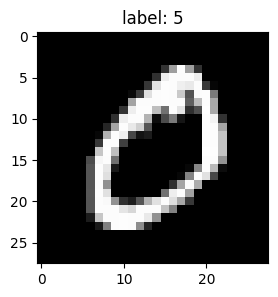

In [2]:
# 绘制训练集中的第一个样本
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(3,3))
plt.imshow(mnist_train.data[1].numpy(), cmap='gray')
plt.title('label: %d' % mnist_train.targets[0])
plt.show()

In [3]:
mnist_train.data[1].shape

torch.Size([28, 28])

## Conv Visualize


$$
H_{out} = \left\lfloor\frac{H_{in}  + 2 \times \text{padding}[0] - \text{dilation}[0]
                        \times (\text{kernel\_size}[0] - 1) - 1}{\text{stride}[0]} + 1\right\rfloor
$$

$$
W_{out} = \left\lfloor\frac{W_{in}  + 2 \times \text{padding}[1] - \text{dilation}[1]
                        \times (\text{kernel\_size}[1] - 1) - 1}{\text{stride}[1]} + 1\right\rfloor
$$

In [4]:
import torch
import torch.nn as nn

In [5]:
class ConvNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1, 
            out_channels=16, 
            kernel_size=5,
            stride=1,
        ) # 1*28*28 -> 16*24*24
        self.pool1 = nn.MaxPool2d(
            kernel_size=2
        ) # 16*24*24 -> 16*12*12
        self.conv2 = nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1
        ) # 16*12*12 -> 32*12*12
        self.pool2 = nn.MaxPool2d(
            kernel_size=2
        ) # 32*12*12 -> 32*6*6
        self.flatten = nn.Flatten() # 32*6*6 -> 1152
        self.fc1 = nn.Linear(32*6*6, 512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)   # 1*28*28 -> 16*24*24
        x = self.relu(x)    # 16*24*24
        x = self.pool1(x)   # 16*24*24 -> 16*12*12
        x = self.conv2(x)   # 16*12*12 -> 32*12*12
        x = self.relu(x)    # 32*12*12
        x = self.pool2(x)   # 32*12*12 -> 32*6*6
        x = self.flatten(x) # 32*6*6 -> 1152
        x = self.fc1(x)     # 1152 -> 512
        x = self.relu(x)    # 512
        x = self.fc2(x)     # 512 -> 10
        return x


In [6]:
model = ConvNN()

In [7]:
X = mnist_train.data[1].detach().numpy()
X = transform(X) # (height, width) numpy array -> (channels, height, width) tensor
X = X.unsqueeze(0) # (batch_size, channels, height, width)

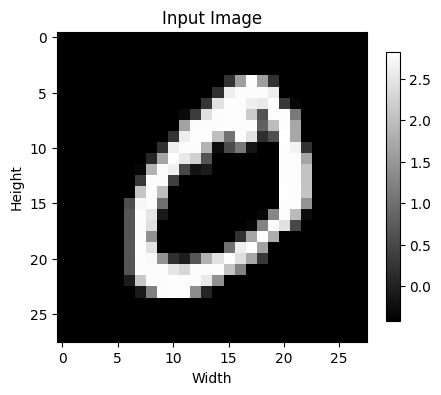

In [8]:
from attention import show_attention
show_attention(
    attention = X[0, 0, :, :], # (height, width)
    xlabel="Width",
    ylabel="Height",
    title="Input Image",
    cmap="gray"
)

In [9]:
X = model.conv1(X) # 1*1*28*28 -> 1*16*24*24

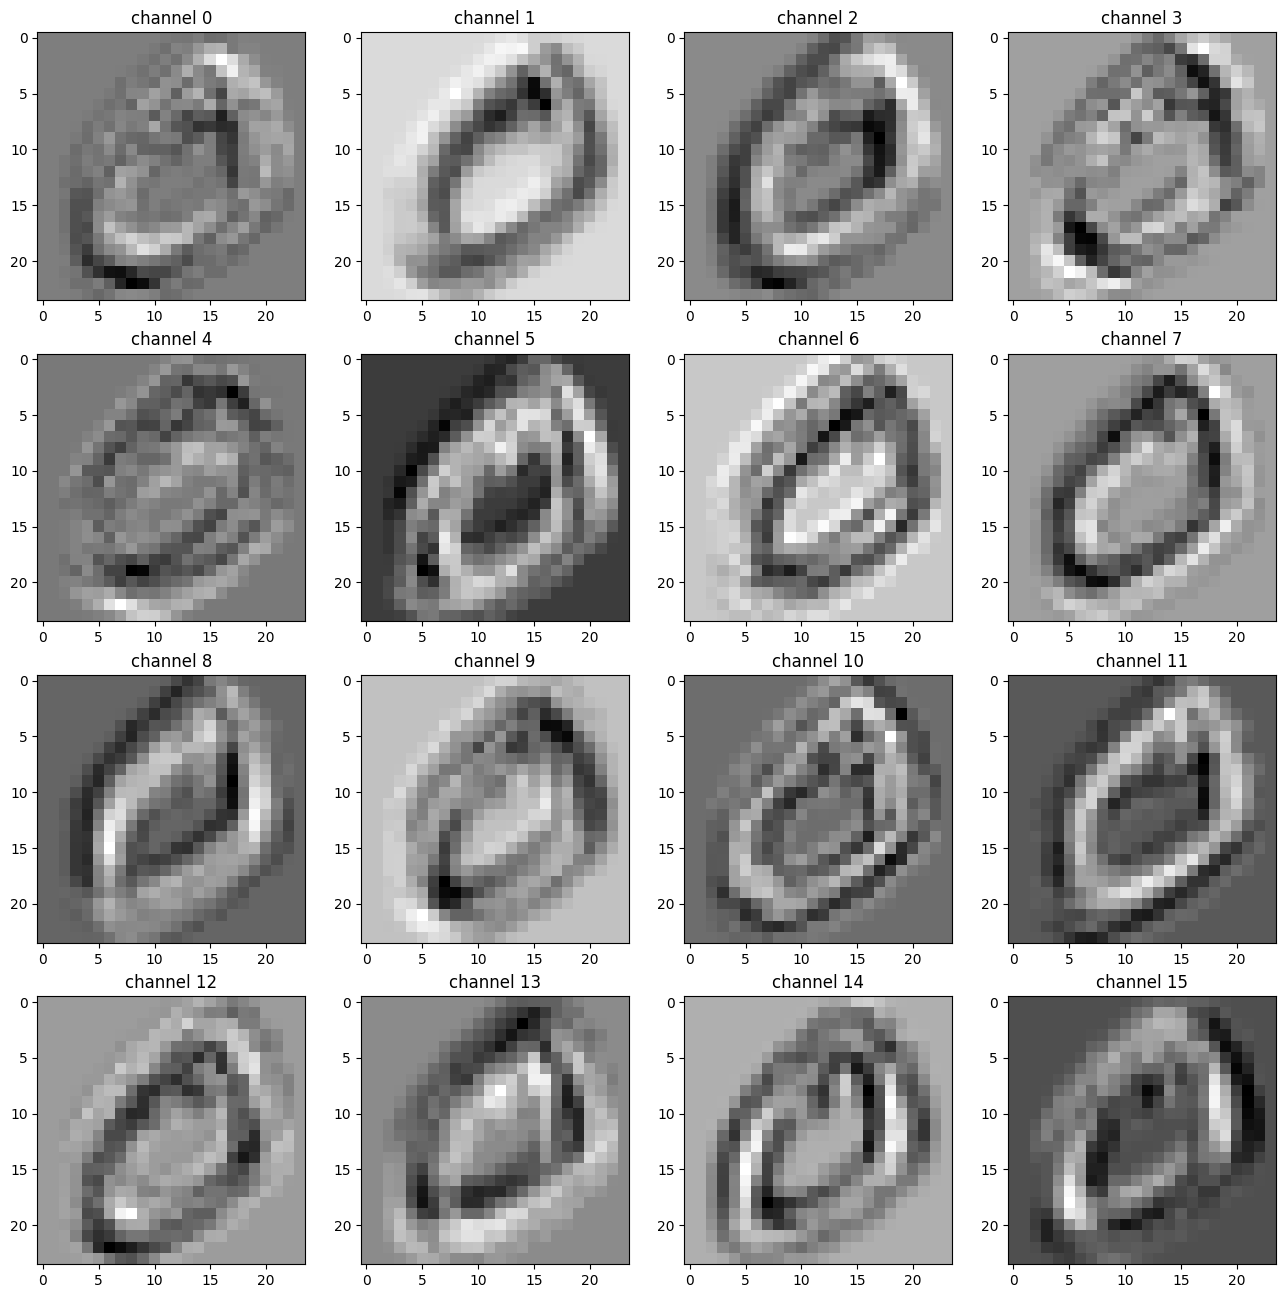

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

def showX(
        X,
        channels=1,
        rows=4, columns=4,
        figsize=(16, 16),
        hspace=0.2, wspace=0.2,
    ):
    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(hspace=hspace, wspace=wspace)
    for i in range(channels):
        ax = fig.add_subplot(rows, columns, i+1)
        ax.imshow(
            X[0, i, :, :].detach().numpy(), 
            cmap='gray'
        )
        ax.set_title('channel %d' % i)
    plt.show()

showX(X, channels=16, rows=4, columns=4)

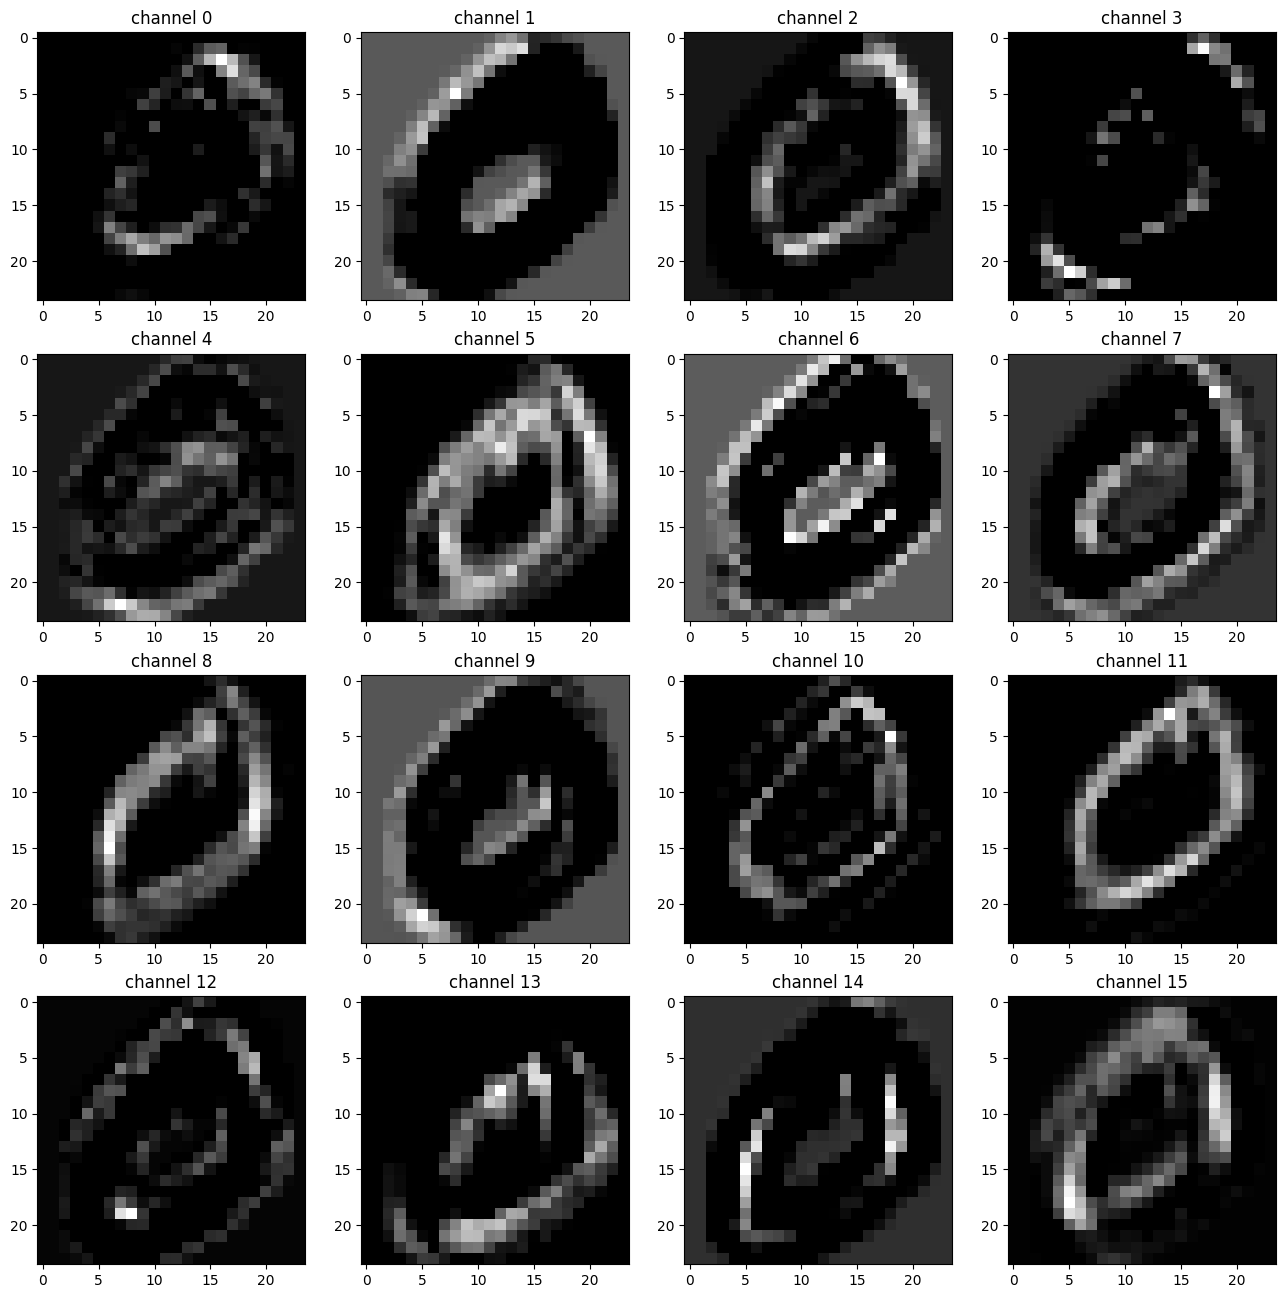

In [11]:
X = model.relu(X) # 1*16*24*24 -> 1*16*24*24
showX(X, channels=16, rows=4, columns=4)

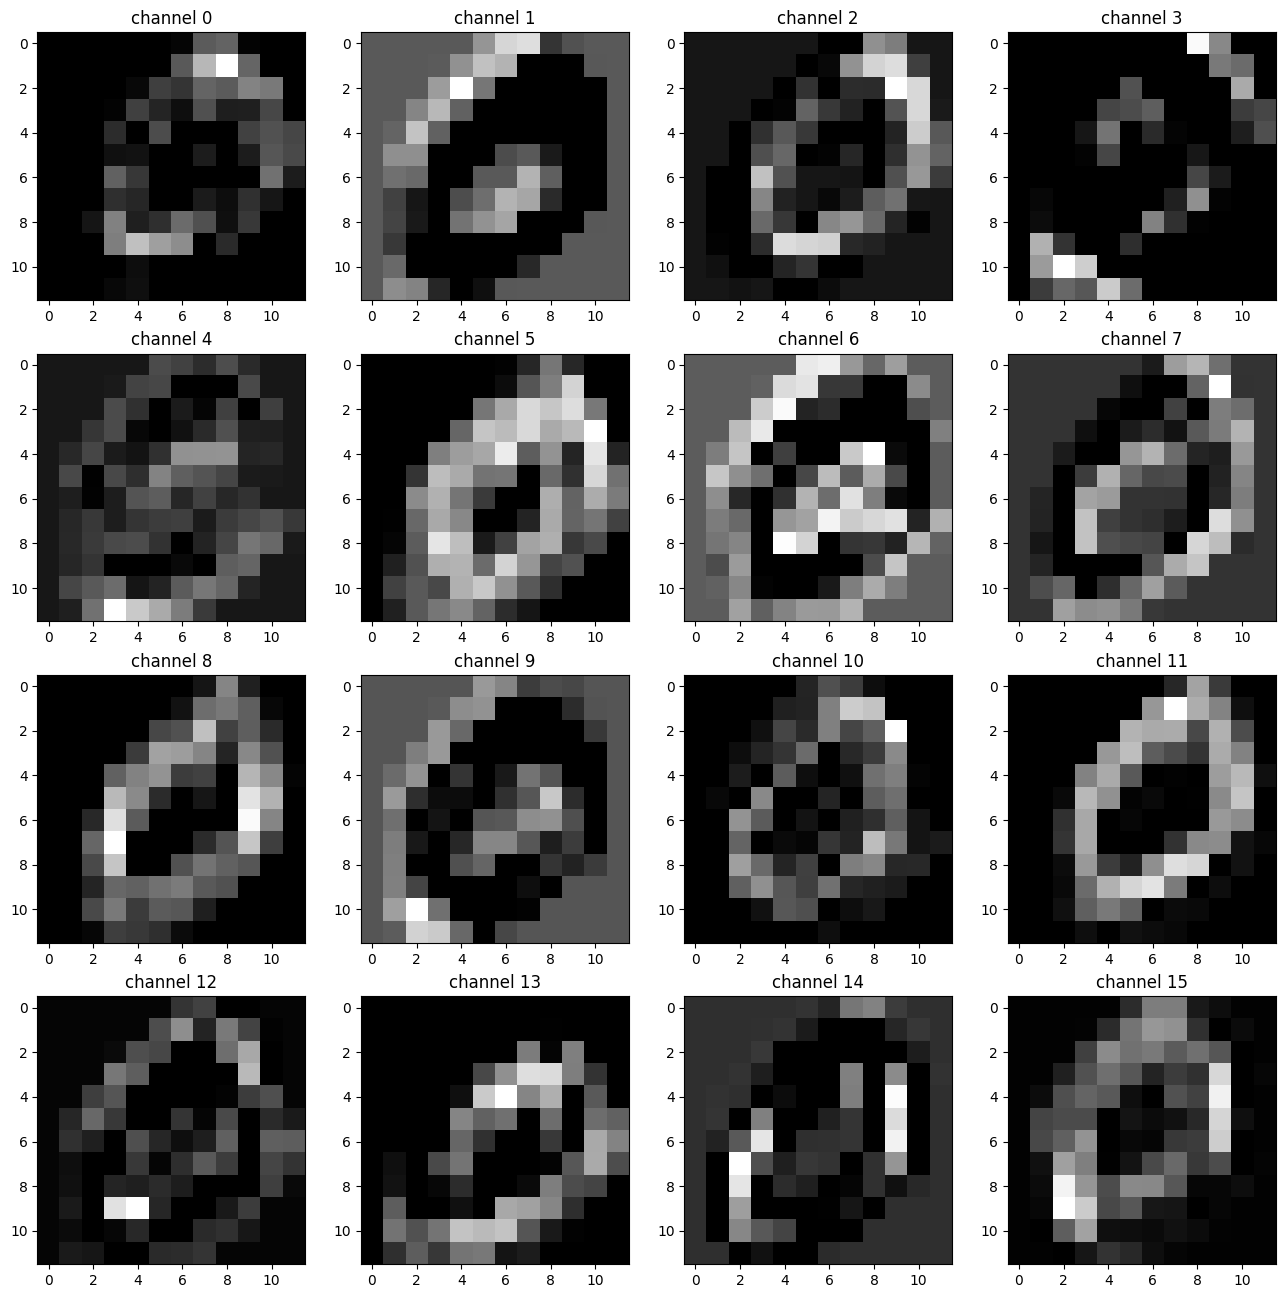

In [12]:
X = model.pool1(X) # 1*16*24*24 -> 1*16*12*12
showX(X, channels=16, rows=4, columns=4)

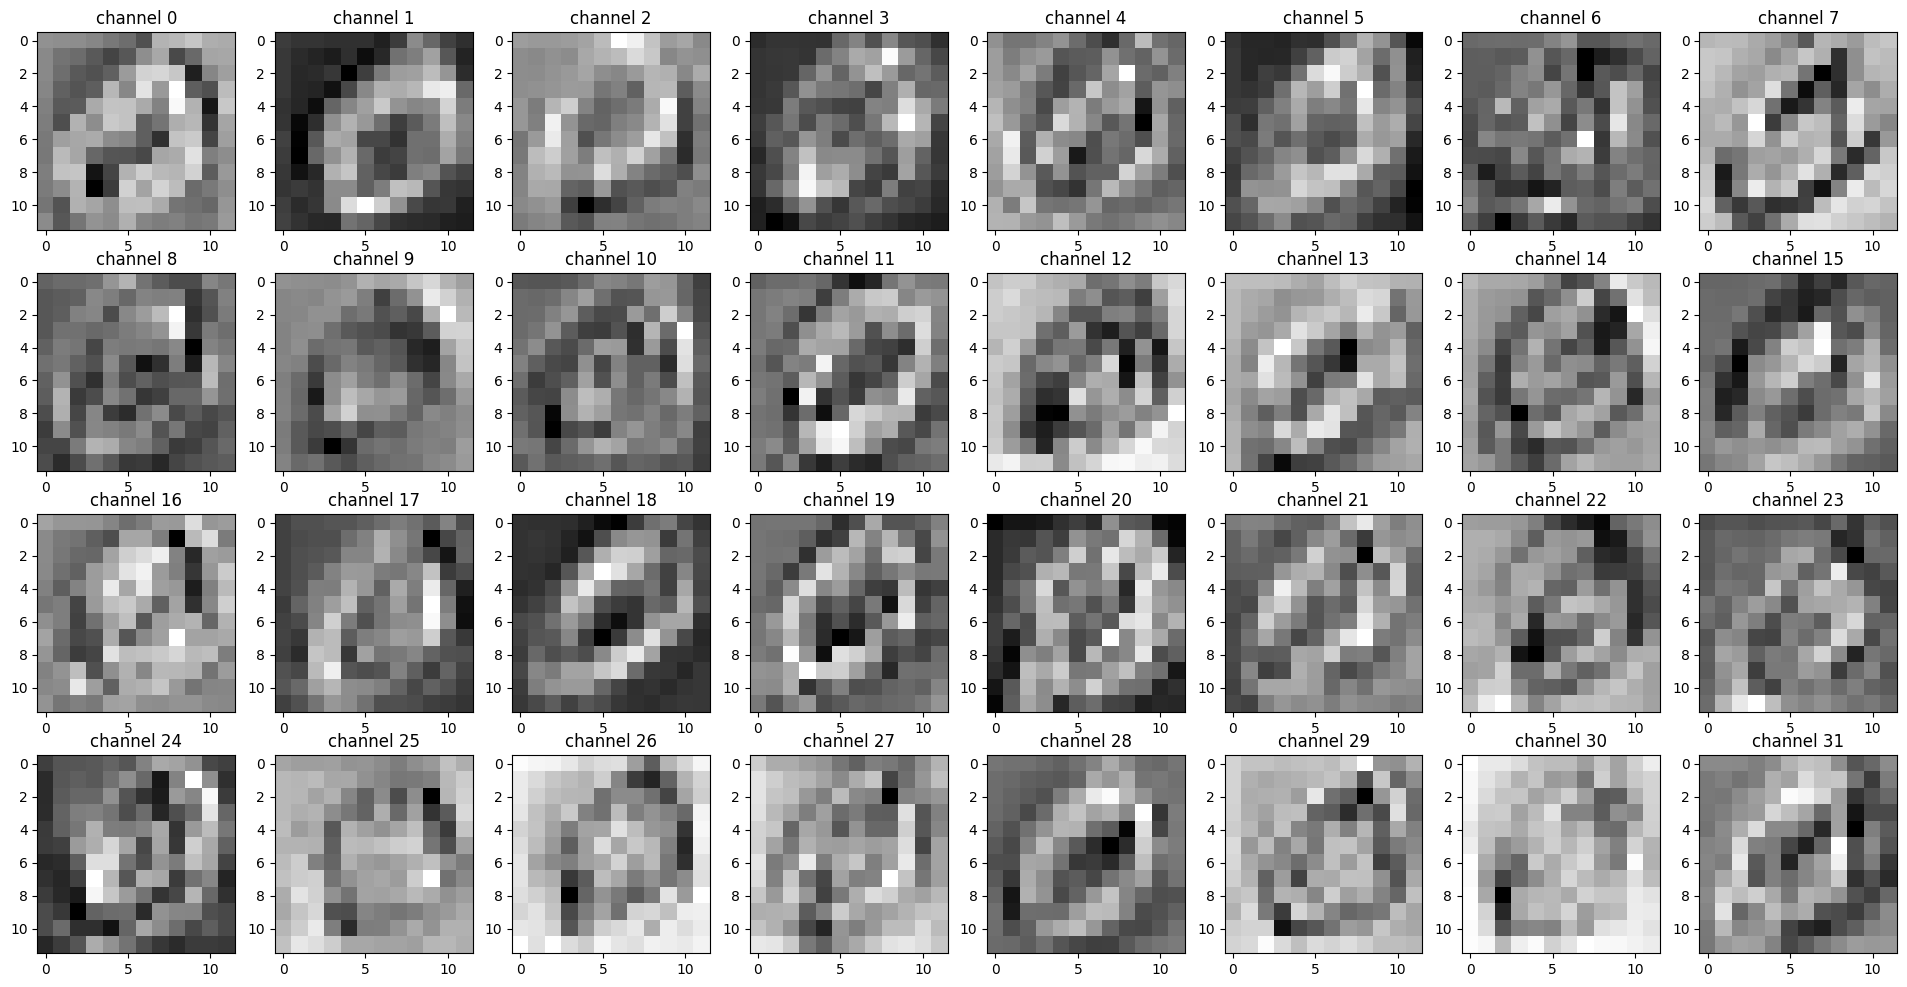

In [13]:
X = model.conv2(X) # 1*16*12*12 -> 1*32*12*12
showX(X, channels=32, rows=4, columns=8, figsize=(24, 12))

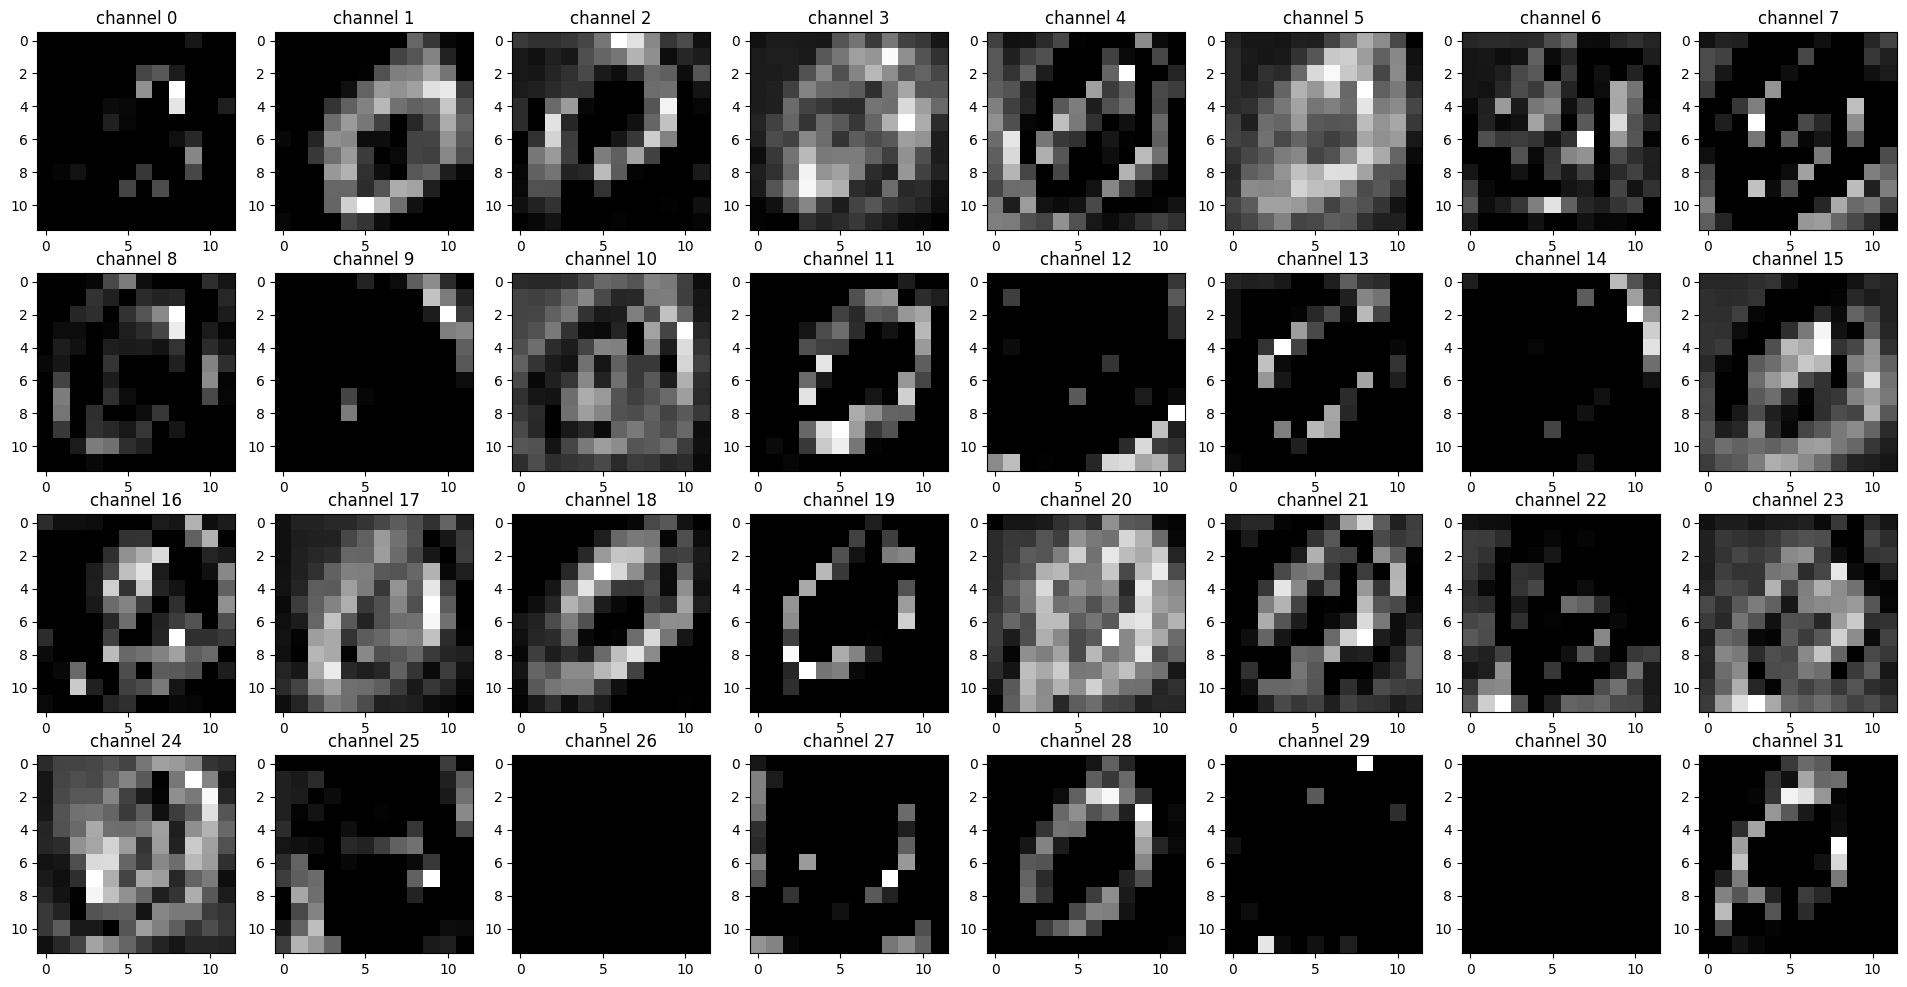

In [14]:
X = model.relu(X) # 1*32*12*12 -> 1*32*12*12
showX(X, channels=32, rows=4, columns=8, figsize=(24, 12))

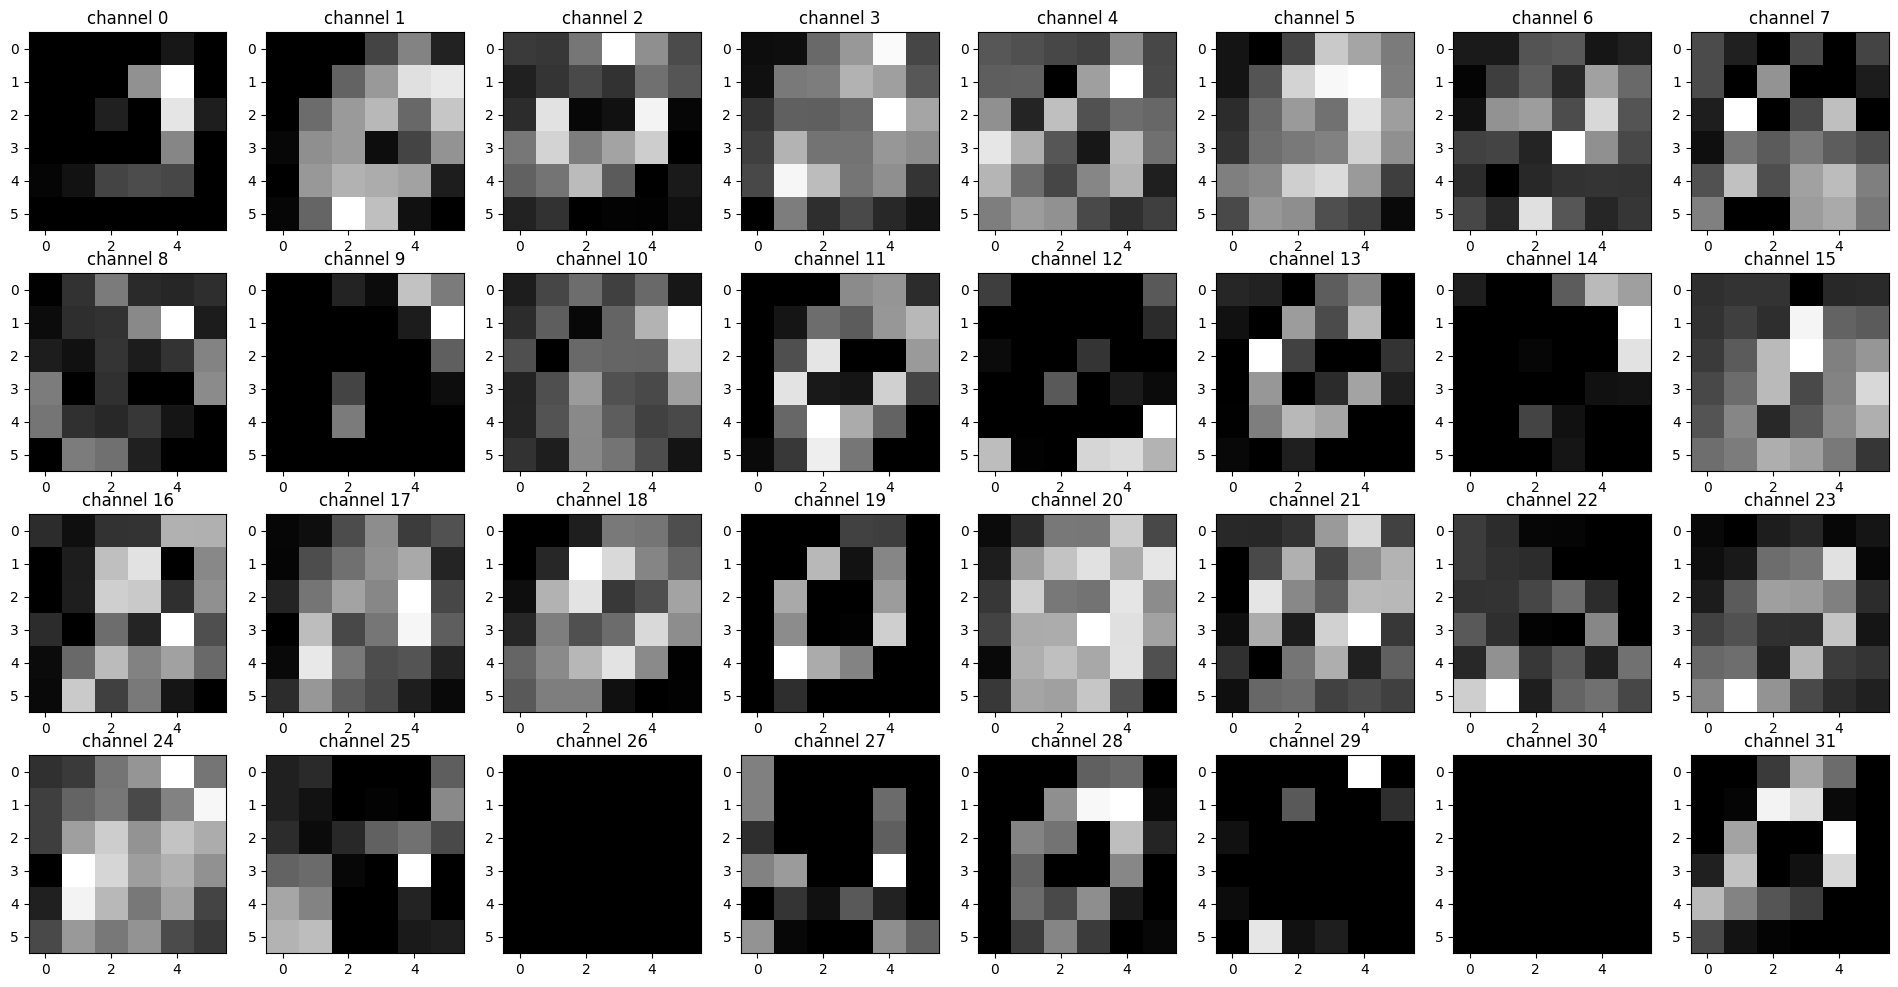

In [15]:
X = model.pool2(X) # 1*32*12*12 -> 1*32*6*6
showX(X, channels=32, rows=4, columns=8, figsize=(24, 12))

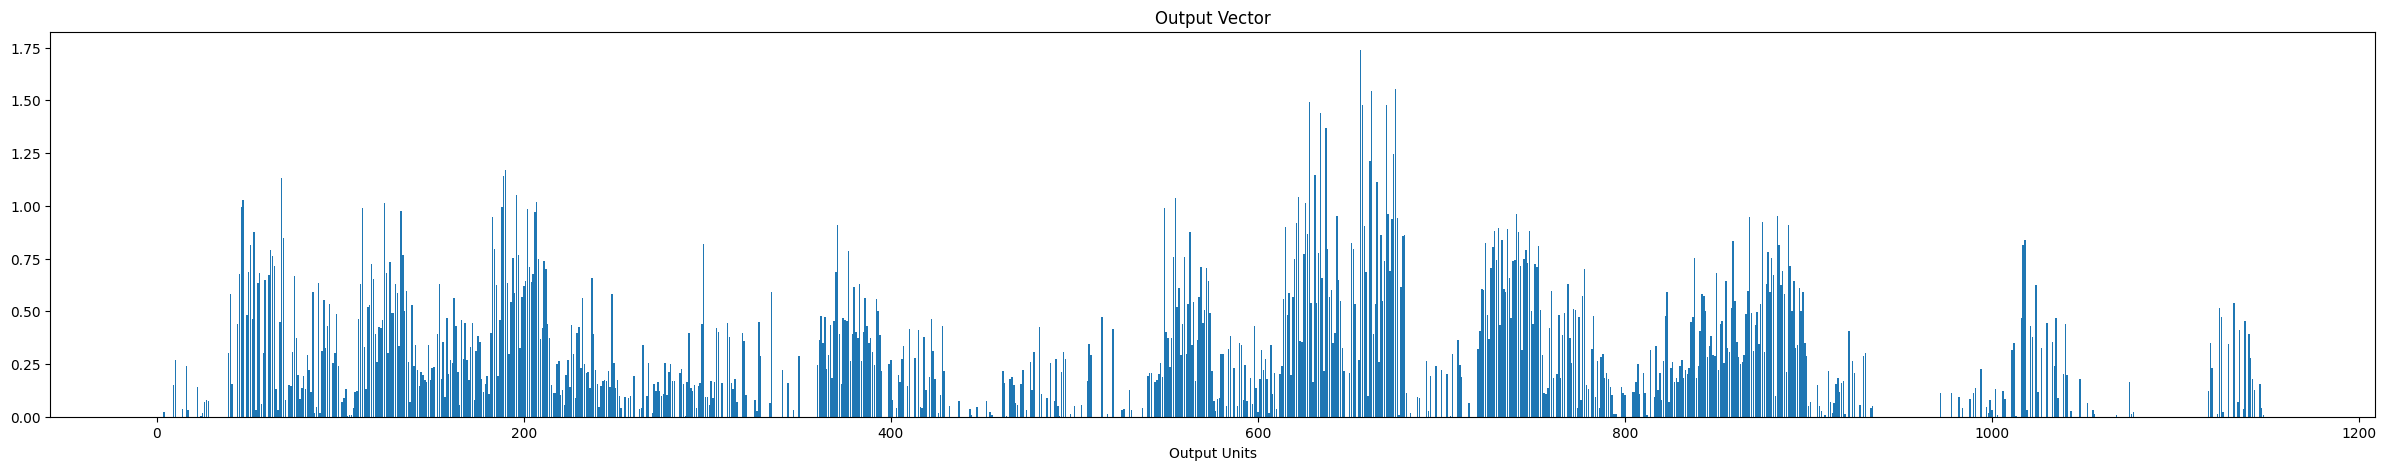

In [16]:
X = model.flatten(X) # 1*32*6*6 -> 1*1152
fig = plt.figure(figsize=(30, 5))
plt.bar(range(1152), X.detach().numpy()[0])
plt.xlabel("Output Units")
plt.title("Output Vector")
plt.show()

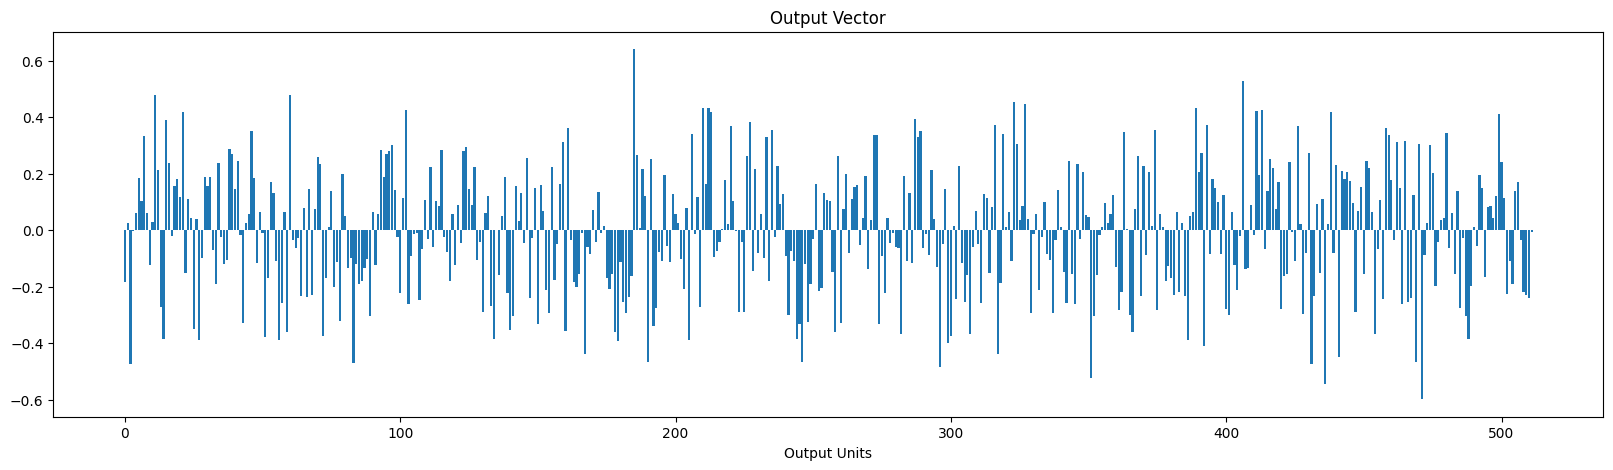

In [17]:
X = model.fc1(X) # 1*1152 -> 1*512
fig = plt.figure(figsize=(20, 5))
plt.bar(range(512), X.detach().numpy()[0])
plt.xlabel("Output Units")
plt.title("Output Vector")
plt.show()

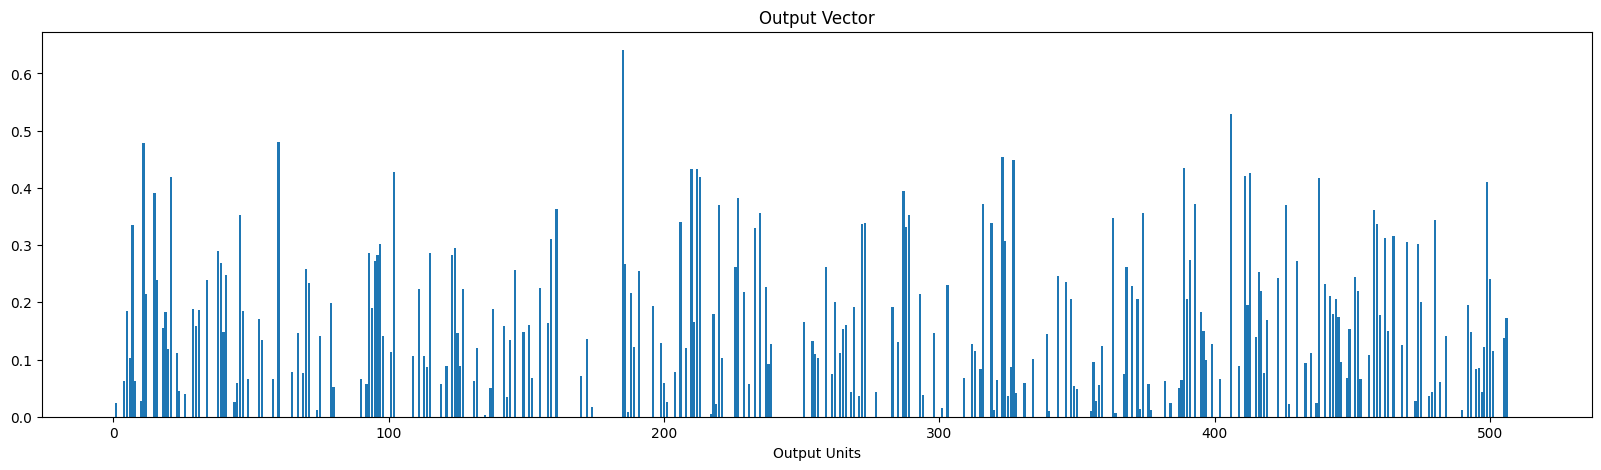

In [18]:
X = model.relu(X) # 1*512 -> 1*512
fig = plt.figure(figsize=(20, 5))
plt.bar(range(512), X.detach().numpy()[0])
plt.xlabel("Output Units")
plt.title("Output Vector")
plt.show()

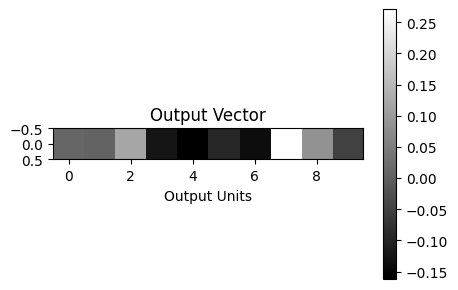

In [19]:
X = model.fc2(X) # 1*512 -> 1*10
show_attention(
    attention = X,
    xlabel="Output Units",
    ylabel="",
    title="Output Vector",
    figsize=(5, 5),
    cmap="gray"
)

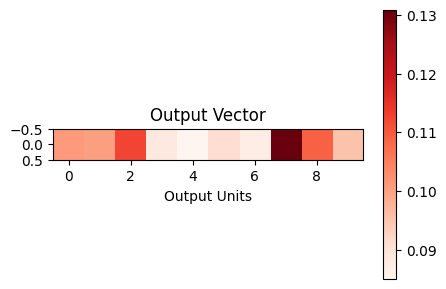

In [20]:
show_attention(
    attention = nn.Softmax(dim=1)(X),
    xlabel="Output Units",
    ylabel="",
    title="Output Vector",
    figsize=(5, 5),
    cmap="Reds"
)

In [21]:
import numpy as np
np.argmax(nn.Softmax(dim=1)(X).detach().numpy())

7

In [22]:
np.argmax(X.detach().numpy())

7